# Test the model of PCA+left/right landmarks position+SVM

In [1]:
from cnn_utils import *
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential,Model
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, InputLayer, BatchNormalization, Dropout
from keras.optimizers import Adam
import seaborn as sns
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

Using TensorFlow backend.


In [2]:
df = create_dataframe('/../raw_data/dataset_071220.json',image_size=(25,50))
df.head()

,eyeImage,leftEye,rightEye,y
0,"[[[0.43529411764705883, 0.41568627450980394, 0...","[-0.06916704732662149, 0.19730078279591035, -0...","[0.17425771877389162, 0.21639015714266296, 0.2...","[-0.30000000000000004, -0.3019517795637199]"
1,"[[[0.15294117647058825, 0.12156862745098039, 0...","[-0.17658285534307594, 0.18033866676032262, -0...","[0.06629549190581052, 0.1988126179958256, 0.10...","[0.30000000000000004, -0.9012629161882894]"
2,"[[[0.1607843137254902, 0.13333333333333333, 0....","[-0.17382043840055927, 0.17981051564675177, -0...","[0.06089991895895852, 0.18628686237123016, 0.0...","[0.8999999999999999, -0.9012629161882894]"
3,"[[[0.17254901960784313, 0.12941176470588237, 0...","[-0.15968611544730582, 0.18524077990937093, -0...","[0.08123800929222913, 0.1904861112443328, 0.11...","[-0.30000000000000004, 0.8989667049368542]"
4,"[[[0.4980392156862745, 0.4627450980392157, 0.5...","[-0.07825260742468576, 0.16963032408957468, -0...","[0.1666792245722788, 0.19617187288354976, 0.20...","[-0.30000000000000004, 0.2996555683122848]"


 ### Reduce to 125 dimension would be sufficient in our case

## 1. PCA+logit

Do not need to scale images before feeding into PCA as the previous experiments shows the performance is similar.

### Find the best C for this task

In [137]:
X_train, X_test, y_train, y_test = train_test_split(df.loc[:,df.columns!="y"],df.loc[:,df.columns=="y"], test_size=0.01)

y_train_binary = create_binary_labels(y_train)
y_test_binary = create_binary_labels(y_test)

eyeImage_train = np.stack(X_train['eyeImage'].to_numpy())
eyeImage_test = np.stack(X_test['eyeImage'].to_numpy())

leftEye_train = np.stack(X_train['leftEye'].to_numpy())
leftEye_test = np.stack(X_test['leftEye'].to_numpy())

rightEye_train = np.stack(X_train['rightEye'].to_numpy())
rightEye_test = np.stack(X_test['rightEye'].to_numpy())

# reshape to make it possible to feed into SVM
eyeImage_train = eyeImage_train.reshape(eyeImage_train.shape[0],eyeImage_train.shape[1]*eyeImage_train.shape[2]*eyeImage_train.shape[3])
eyeImage_test = eyeImage_test.reshape(eyeImage_test.shape[0],eyeImage_test.shape[1]*eyeImage_test.shape[2]*eyeImage_test.shape[3])

# model part
pca = PCA(n_components=125, whiten=True)
scalar = StandardScaler()
logit = LogisticRegression(solver='saga', penalty='l1')

# prepare the input training data
pca.fit(eyeImage_train)
eyeImage_train = pca.transform(eyeImage_train)
input_train = np.concatenate((eyeImage_train, leftEye_train, rightEye_train), axis=1)
# input_train =eyeImage_train
scalar.fit(input_train)
input_train = scalar.transform(input_train)

grid = GridSearchCV(estimator=logit, param_grid={'C':[i*0.01 for i in range(10,51)]})
grid.fit(input_train, y_train_binary)

GridSearchCV(estimator=LogisticRegression(penalty='l1', solver='saga'),
             param_grid={'C': [0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17,
                               0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25,
                               0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33,
                               0.34, 0.35000000000000003, 0.36, 0.37, 0.38,
                               0.39, ...]})

In [138]:
grid.best_estimator_

LogisticRegression(C=0.19, penalty='l1', solver='saga')

In [110]:
def pca_logit_robustness(df):
    """
    For testing the robustness of our PCA+SVM model when we split the train and test randomly
    """
    train_scores, test_scores = [], []
    for i in range(50):
        X_train, X_test, y_train, y_test = train_test_split(df.loc[:,df.columns!="y"],df.loc[:,df.columns=="y"], test_size=0.3)

        eyeImage_train = np.stack(X_train['eyeImage'].to_numpy())
        eyeImage_test = np.stack(X_test['eyeImage'].to_numpy())
        y_train_binary = create_binary_labels(y_train)
        y_test_binary = create_binary_labels(y_test)

        # reshape to make it possible to feed into SVM
        eyeImage_train = eyeImage_train.reshape(eyeImage_train.shape[0],eyeImage_train.shape[1]*eyeImage_train.shape[2]*eyeImage_train.shape[3])
        eyeImage_test = eyeImage_test.reshape(eyeImage_test.shape[0],eyeImage_test.shape[1]*eyeImage_test.shape[2]*eyeImage_test.shape[3])
        pca = PCA(n_components=125, whiten=True)
        logit = LogisticRegression(penalty='l1', solver='saga',C=0.163)
        logit_model = make_pipeline(pca, logit)
        logit_model.fit(eyeImage_train, y_train_binary)
        # param_grid = {'svc__C': [100,50,10,5,1,0.5,0.1, 0.05, 0.01, 0.005, 0.001]}
        # grid = GridSearchCV(svm_model, param_grid)
        # %time grid.fit(eyeImage_train, y_train_binary)
        # print(grid.best_params_)

        # svm_model = grid.best_estimator_

        train_score = logit_model.score(eyeImage_train, y_train_binary, sample_weight=None)
        test_score = logit_model.score(eyeImage_test, y_test_binary, sample_weight=None)

        train_scores.append(train_score)
        test_scores.append(test_score)
        logit_model = None

    data = {'train_score':train_scores, 'test_score':test_scores}

    return pd.DataFrame(data)

In [111]:
logit_df = pca_logit_robustness(df)

Text(0.5, 1.0, 'Acc of PCA+logitL1 in 100 rand splits')

<Figure size 432x288 with 0 Axes>

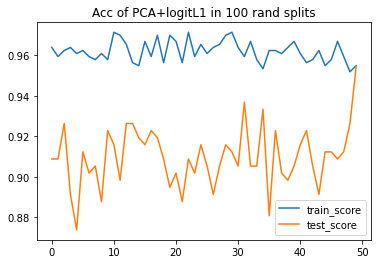

In [112]:
plt.figure()
logit_df.plot()
plt.legend(loc="best")
plt.title("Acc of PCA+logitL1 in 100 rand splits")
# plt.savefig("./results/.png")

In [113]:
logit_df.mean(axis=0)

train_score    0.962045
test_score     0.909754
dtype: float64

In [114]:
logit_df.std(axis=0)

train_score    0.005107
test_score     0.014649
dtype: float64

## 2. Add left/right eye position information

In [154]:
def pca_logitl1_positions_robustness(df):
    train_scores, test_scores = [], []
    for i in range(50):
        X_train, X_test, y_train, y_test = train_test_split(df.loc[:,df.columns!="y"],df.loc[:,df.columns=="y"], test_size=0.3)

        y_train_binary = create_binary_labels(y_train)
        y_test_binary = create_binary_labels(y_test)

        eyeImage_train = np.stack(X_train['eyeImage'].to_numpy())
        eyeImage_test = np.stack(X_test['eyeImage'].to_numpy())

        leftEye_train = np.stack(X_train['leftEye'].to_numpy())
        leftEye_test = np.stack(X_test['leftEye'].to_numpy())

        rightEye_train = np.stack(X_train['rightEye'].to_numpy())
        rightEye_test = np.stack(X_test['rightEye'].to_numpy())

        # reshape to make it possible to feed into SVM
        eyeImage_train = eyeImage_train.reshape(eyeImage_train.shape[0],eyeImage_train.shape[1]*eyeImage_train.shape[2]*eyeImage_train.shape[3])
        eyeImage_test = eyeImage_test.reshape(eyeImage_test.shape[0],eyeImage_test.shape[1]*eyeImage_test.shape[2]*eyeImage_test.shape[3])

        # model part
        pca = PCA(n_components=125, whiten=True)
        scalar = StandardScaler()
        logit = LogisticRegression(penalty='l1',solver='saga',C=0.20) 

        # prepare the input training data
        pca.fit(eyeImage_train)
        eyeImage_train = pca.transform(eyeImage_train)
        input_train = np.concatenate((eyeImage_train, leftEye_train, rightEye_train), axis=1)
        # input_train =eyeImage_train
        scalar.fit(input_train)
        input_train = scalar.transform(input_train)


        logit.fit(input_train, y_train_binary)
        train_score = logit.score(input_train, y_train_binary, sample_weight=None)

        # prepare the input testing data
        eyeImage_test = pca.transform(eyeImage_test)
        input_test = np.concatenate((eyeImage_test, leftEye_test, rightEye_test), axis=1)
        # input_test =eyeImage_test
        input_test = scalar.transform(input_test)

        test_score = logit.score(input_test, y_test_binary, sample_weight=None)

        logit, pca, scalar = None, None, None
        train_scores.append(train_score)
        test_scores.append(test_score)

    data = {'train_score':train_scores, 'test_score':test_scores}

    return pd.DataFrame(data)

In [155]:
position_df = pca_logitl1_positions_robustness(df)

In [156]:
position_df.mean(axis=0)

train_score    0.967218
test_score     0.910456
dtype: float64

In [151]:
position_df.std(axis=0)

train_score    0.005260
test_score     0.014461
dtype: float64

<Figure size 432x288 with 0 Axes>

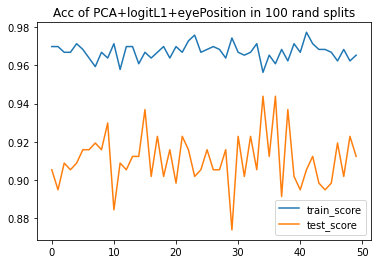

In [157]:
plt.figure()
position_df.plot()
plt.legend(loc="best")
plt.title("Acc of PCA+logitL1+eyePosition in 100 rand splits")
# plt.savefig("./results/P.png")